In [1]:
import jax 
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np 
import flax.linen as nn 
import jax.tree_util as jtu    
from jax import vmap, lax, jit 
from jax.scipy.stats import norm, rankdata
from jax.scipy.special import digamma
from jax.scipy.special import gamma
from jax.scipy.linalg import cholesky
from functools import partial
from typing import NamedTuple
from flax import struct

plt.rcParams['font.size'] = 20
DATA_PATH = '/Users/juancarlos/noncanonical-olfaction/rbm/mm_synthetic_data_non_zero_samples_9_April_2025.npy'

In [54]:
def sigmoid_log(x): 
    return x / (x + 1) 

# these registries are so that we can pass these different functions as options around through the class hyperparamters, while keeping hp hashable (so it can be static) 
NL_REGISTRY = {
    'sigmoid log': sigmoid_log,
    'relu': jax.nn.relu,
    'tanh': jax.nn.tanh,
    'id': lambda x : x
}

ACTIVITY_FUNCTION_REGISTRY = {
    'linear filter': compute_linear_filter_activity, 
    'antagonism': compute_osn_firing_with_antagonism
}

PHI_PSI_REGISTRY = {
    'softplus_phi': lambda u: jax.nn.softmax(u, axis=1), # rows of expression matrix should sum to 1. 
    'softplus_psi': lambda x: jnp.log(jnp.clip(x, min=1e-6, max=1-1e-6)), 
    'bounded_phi': lambda u: 1 / (1 + jnp.exp(-u)), 
    'bounded_psi': lambda x: jnp.log(jnp.clip(x, min=1e-6, max=1-1e-6) / (1 - jnp.clip(x, 1e-6, 1-1e-6))), 
    'positive_phi': jnp.exp,
    'positive_psi': jnp.log
}

LOSS_REGISTRY = {
    'jensen_shannon_loss': jensen_shannon_loss,
    'entropy_loss': entropy_loss, 
    'log_det_loss': log_det_loss
}

ODOR_MODEL_REGISTRY = {
    'data-driven binary': draw_cs_data_driven_binary, 
    'data-driven log normal': draw_cs_data_driven_log_normal, 
    'log normal': draw_cs_sparse_log_normal
}

class HyperParams(NamedTuple):
    N: int = 100 # number of odorants. this needs to match the number of variables (rows) in the data when using the data driven model. 
    n: int = 2 # sparsity of odor vectors--only applies for the Qin et al 2019 odor model 
    M: int = 30 # number of odorant receptors
    L: int = 300 # number of olfactory receptor neurons 
    P: int = 1000 # number of samples when we compute MI
    window: int = 32 # this should be set to jnp.round(jnp.sqrt(P) + 0.5).astype(int) but doing this dynamically makes hp not hashable. So change it when you change P!
    sigma_0: float = 0.01 # neural noise in Gaussian linear filter model 
    sigma_c: float = 2.0 # std_dev of log normal Qin et al 2019 odorant model 
    nonlinearity: str = 'sigmoid log'
    F_max: float = 25.0
    hill_exponent: int = 4
    odor_model: str = 'log normal'
    activity_model: str = 'linear filter'
    loss: str = 'jensen_shannon_loss'
    phi: str = 'softplus_phi'
    psi: str = 'softplus_psi'

@struct.dataclass
class Params: 
    W: jnp.ndarray
    E: jnp.ndarray
    kappa_inv: jnp.ndarray
    eta: jnp.ndarray # these are not going to be changed during training, but you can't hash a tuple with jax arrays, so here they shall live. 
    
class T_estimator(nn.Module):
    hidden_dim: int = 128

    def g_f(self, v): 
        return jnp.clip(jnp.log(2) - jnp.log(1 + jnp.exp(-v)), max=jnp.log(2) - 1e-6) # see Table 2 of https://arxiv.org/pdf/1606.00709
    
    @nn.compact
    def __call__(self, c, r): 
        # batch should be the first dimension here. this is contra everything else in our pipeline, so be careful! transpose just before passing in c and r
        r = nn.Dense(self.hidden_dim)(r) 
        r = nn.tanh(r) 
        r = nn.Dense(self.hidden_dim)(r) 
        r = nn.tanh(r) 
        c = nn.Dense(self.hidden_dim)(c) 
        c = nn.tanh(c) 
        c = nn.Dense(self.hidden_dim)(c) 
        c = nn.tanh(c) 
        # Dot product for each sample
        v = jnp.einsum("bi,bi->b", c, r)  # or use vmap(jnp.dot)(c, r)
        return self.g_f(v)

    # @nn.compact     
    # def __call__(self, c, r):
    #     # Concatenate c (P, N) and r (P, L) -> (P, N + L)
    #     x = jnp.concatenate([c, r], axis=1)
    #     x = nn.Dense(self.hidden_dim)(x)
    #     x = nn.relu(x) 
    #     x = nn.Dense(self.hidden_dim)(x)
    #     x = nn.relu(x)
    #     v = nn.Dense(1)(x)
    #     return self.g_f(v) 
    
@struct.dataclass
class TrainingState:
    p: any           # Your primal parameters
    Tp: any          # MINE network parameters
    key: jax.Array   # PRNG key
    metrics: dict 

In [46]:
def create_one_hot_array(key, L, M):
    indices = jax.random.randint(key, (L,), 0, M)
    return jax.nn.one_hot(indices, M, dtype=jnp.int32)

In [47]:
def init(rng, scale=1, hp=None, sigma_kappa_inv=4.0, rho=0, canonical_init=False, balanced=False) -> Params: 
    if hp is None: 
        hp = HyperParams() 
    W_key, E_key, z_key, eta_key = jax.random.split(rng, 4) 
    W = jnp.clip(scale * jax.random.gamma(W_key, a=1, shape=(hp.M, hp.N)), min=1e-6, max=1-1e-6)
    if canonical_init:
        # better than this: just choose random entries to be 1 so that each row has 1 1 and the rest are 0s. 
        if balanced:
            try: 
                E  = jnp.repeat(jnp.eye(hp.M), hp.L//hp.M, axis=0) # this is a canonical initialization with exactly equal numbers representing each receptor 
            except:  
                raise ValueError("For balanced canonical initialization, set L to a postive multiple of M")
        else: 
            E = create_one_hot_array(E_key, hp.L, hp.M)
    else: 
        phi = PHI_PSI_REGISTRY[hp.phi]
        E = phi(.5 + .1 * jax.random.normal(E_key, shape = (hp.L, hp.M))) # this is a noncanonical initialization where every neuron expresses roughly the same amount of every receptor. 
    # kappa_inv = jax.random.lognormal(kappa_inv_key, sigma=sigma_kappa_inv, shape=(hp.M, hp.N)) # see "Olfactory Encoding Model" in Reddy and Zak 2018
    eta = jax.random.lognormal(eta_key, shape=(hp.M, hp.N))
    z = jax.random.normal(z_key, shape=(hp.M, hp.N)) 
    kappa_inv = jnp.exp(sigma_kappa_inv * (rho * jnp.log(eta) + jnp.sqrt(1 - rho**2) * z))
    
    return hp, Params(W, E, kappa_inv, eta)

In [48]:
# for x >= 0: use phi = jnp.exp, psi = jnp.log 
# for x \in [0, 1] use below
def phi(u): 
    return 1 / (1 + jnp.exp(-u))

def psi(x): 
    x = jnp.clip(x, min=1e-6, max=1-1e-6)
    return jnp.log(x / (1 - x))

def phi(u): 
    return jax.nn.softmax(u, axis=1)

def psi(x): 
    return jnp.log(jnp.clip(x, min=1e-6, max=1-1e-6))

In [49]:
def draw_c_sparse_log_normal(subkey, hp): 
    c = jnp.zeros(hp.N)
    sub1, sub2 = jax.random.split(subkey) 
    non_zero_indices = jax.random.choice(sub1, hp.N, shape=(hp.n,), replace=False)
    concentrations = jax.random.lognormal(sub2, sigma=hp.sigma_c, shape=(hp.n,))
    c = c.at[non_zero_indices].set(concentrations)
    return c

def draw_cs_sparse_log_normal(subkey, hp): 
    keybatch = jax.random.split(subkey, hp.P)
    cs = vmap(draw_c_sparse_log_normal, in_axes=(0, None))(keybatch, hp).T 
    return cs 

def closure_draw_cs_data_driven(path): # closures are nice https://apxml.com/courses/advanced-jax/chapter-1-advanced-jax-transformations-control-flow/closures-jax-staging
    loaded_data = jnp.load(path)
    P_total = loaded_data.shape[1]
    
    def draw_cs_data_driven_binary(subkey, hp):
        idx = jax.random.choice(subkey, P_total, shape=(hp.P,), replace=True)
        batch = jax.device_put(loaded_data[:, idx])  # move to device only once per call
        return batch  # shape (N, P), like the log_normal one
    
    def draw_cs_data_driven_log_normal(subkey, hp):
        subkey_index, subkey_concentration = jax.random.split(subkey)
        idx = jax.random.choice(subkey_index, P_total, shape=(hp.P,), replace=True)
        batch = jax.device_put(loaded_data[:, idx])  # move to device only once per call
        batch = jnp.where(batch, jax.random.lognormal(subkey_concentration, sigma=hp.sigma_c, shape=batch.shape), jnp.zeros(batch.shape))
        return batch 
    
    return draw_cs_data_driven_binary, draw_cs_data_driven_log_normal

draw_cs_data_driven_binary, draw_cs_data_driven_log_normal = closure_draw_cs_data_driven(DATA_PATH)

def compute_receptor_activity(subkey, hp, p, c):
    pre_activations = p.W @ c
    nl = NL_REGISTRY[hp.nonlinearity]
    r = nl(pre_activations) + hp.sigma_0 * jax.random.normal(subkey, shape=pre_activations.shape) 
    return r

def compute_linear_filter_activity(hp, p, c, subkey):
    receptor_activations = p.W @ c # p.W is receptor x odorant 
    c_AMP = p.E @ receptor_activations # p.E is neuron x receptor 
    nl = NL_REGISTRY[hp.nonlinearity] 
    r = nl(c_AMP) + hp.sigma_0 * jax.random.normal(subkey, shape=c_AMP.shape)
    return r

def compute_osn_firing_rate_with_antagonism(hp, p, c):
    '''generalized version of equation 14 in Reddy, Zak et al. 2018. eta and kappa_inv are receptor x odorant, and the gene expression matrix p.E is neuron x receptor''' 
    receptor_induced_activities = p.E @ (jnp.matmul((p.eta * p.kappa_inv), c) / (1 + jnp.matmul(p.kappa_inv, c))) 
    denominator = 1 + receptor_induced_activities**-hp.hill_exponent 
    F = hp.F_max / denominator
    return F

def compute_osn_firing_with_antagonism(hp, p, c, subkey):
    firing_rate = compute_osn_firing_rate_with_antagonism(hp, p, c)
    # firing = jax.random.poisson(subkey, lam=firing_rate)
    firing = firing_rate + hp.sigma_0 * jax.random.normal(subkey, shape=firing_rate.shape)
    return firing # this should be neuron x samples, where c is odorants x samples 

# @partial(jit, static_argnames=['hp'])
def compute_entropy(r, hp):
    entropy = compute_sum_of_marginal_entropies(r, hp) - compute_information(r)
    return entropy

def compute_sum_of_marginal_entropies(r, hp):
    compute_entropy_vmap = vmap(vasicek_entropy, in_axes=(0, None))
    marginal_entropies = compute_entropy_vmap(r, hp)
    return jnp.sum(marginal_entropies)

def vasicek_entropy(X, hp): # see https://github.com/scipy/scipy/blob/main/scipy/stats/_entropy.py#L378
    n = X.shape[-1]
    X = jnp.sort(X, axis=-1)
    X = pad_along_last_axis(X, hp.window)
    start1 = 2 * hp.window
    length = hp.P
    differences = lax.dynamic_slice(X, (start1,), (length, )) - lax.dynamic_slice(X, (0,), (length,))
    logs = jnp.log(n / (2 * hp.window) * differences)
    return jnp.mean(logs, axis=-1)

def pad_along_last_axis(X, window):
    first_value = X[0]
    last_value = X[-1]
    # Use `lax.full_like` to create padded arrays
    Xl = lax.full_like(x=jnp.empty((window,)), fill_value=first_value)
    Xr = lax.full_like(x=jnp.empty((window,)), fill_value=last_value)
    return jnp.concatenate((Xl, X, Xr))

def compute_information(r): 
    M, P = r.shape
    G = norm.ppf((rankdata(r.T, axis=0) / (P + 1)), loc=0, scale=1) # this is just ranking the data and making it normally distributed. 
    bias_correction = 0.5 * jnp.sum(digamma((P - jnp.arange(1, M + 1) + 1) / 2) - jnp.log(P / 2)) 
    cov_matrix = jnp.cov(G, rowvar=False)
    chol_decomp = cholesky(cov_matrix)
    log_det = jnp.sum(jnp.log(jnp.diag(chol_decomp)))
    I = -(log_det - bias_correction) # remember: entropy overall is sum of marginals minus information. 
    return I

@partial(jax.jit, static_argnames=['hp'])
def entropy_loss(p, hp, cs, subkey):
    r = compute_linear_filter_activity(subkey, hp, p, cs)
    e = compute_entropy(r, hp) 
    return -e 

@partial(jax.jit, static_argnames=['hp'])
def log_det_loss(p, hp, cs, subkey): 
    r = compute_linear_filter_activity(subkey, hp, p, cs)
    cov = jnp.cov(r, rowvar=True) 
    chol_decomp = cholesky(cov) 
    log_det = jnp.sum(jnp.log(jnp.diag(chol_decomp)))
    return -log_det 

def f_star_JSD(t): # see Table 2 of https://arxiv.org/pdf/1606.00709
    return - jnp.log(2 - jnp.exp(t))

def jensen_shannon_loss(p, Tp, hp, cs, key): 
    key, subkey_firing, subkey_shuffle = jax.random.split(key, 3) 
    activity_function = ACTIVITY_FUNCTION_REGISTRY[hp.activity_model]
    r = activity_function(hp, p, cs, subkey_firing) 
    r_shuffled = jax.random.permutation(subkey_shuffle, r, axis=1) 
    T_joint = T_estimator().apply(Tp, cs.T, r.T)
    T_marginal = T_estimator().apply(Tp, cs.T, r_shuffled.T)
    mi_estimate = jnp.mean(T_joint) - jnp.mean(f_star_JSD(T_marginal))
    return - mi_estimate

In [50]:
def flatten_metrics(metrics_list):
    """Convert list of metric dicts to dict of arrays."""
    flattened = {k: [] for k in metrics_list[0].keys()}  # Initialize with keys
    for metrics in metrics_list:
        for k, v in metrics.items():
            flattened[k].extend(v)
    return {k: jnp.array(v) for k, v in flattened.items()} 

@partial(jax.jit, static_argnames=('hp'))
def update_params_T(p, Tp, hp, cs, key, gamma_p, gamma_T):
    # Split keys
    key, loss_key = jax.random.split(key)

    # Compute gradients for MINE network (T) and model params (E)
    if hp.loss != 'jensen_shannon_loss': 
        raise ValueError('only the jensen shannon loss requires a T network. For other losses, use update_params')
    
    loss = LOSS_REGISTRY[hp.loss] 
    phi = PHI_PSI_REGISTRY[hp.phi]
    psi = PHI_PSI_REGISTRY[hp.psi]

    mi_estimate, grads = jax.value_and_grad(
        loss, argnums=(0, 1)
    )(p, Tp, hp, cs, loss_key)
    grads_p, grads_T = grads 

    # Update MINE network (T)

    Tp = jax.tree.map(
    lambda param, grad: param - gamma_T * grad,
    Tp,
    grads_T
    )
    # natural gradient in dual space is equivalent to mirror descent in primal space. A "straight through" trick. 
    #  phi:unconstrained --> constrained, psi is inverse of phi. 
    # see https://vene.ro/blog/mirror-descent.html#generalizing-the-projected-gradient-method-with-divergences for a very clear exposition
    U_current = psi(p.E) # map to dual space 
    U_new = U_current - gamma_p * grads_p.E # grads_p.E is correctly with respect to the primal parameters and evaluated on the primal parameters 
    E_new = phi(U_new) # map back to primal space 
    p = p.replace(E=E_new) 

    return p, Tp, - mi_estimate

def update_params(p, hp, cs, key, gamma_p):
    # Split keys
    key, loss_key = jax.random.split(key)

    loss = LOSS_REGISTRY[hp.loss] 
    phi = PHI_PSI_REGISTRY[hp.phi]
    psi = PHI_PSI_REGISTRY[hp.psi]

    # Compute gradients for MINE network (T) and model params (E)
    mi_estimate, grads_p = jax.value_and_grad(
        loss, argnums=(0)
    )(p, hp, cs, loss_key) # loss needs to have this signature 

    # natural gradient in dual space is equivalent to mirror descent in primal space. A "straight through" trick. 
    #  phi:unconstrained --> constrained, psi is inverse of phi. 
    # see https://vene.ro/blog/mirror-descent.html#generalizing-the-projected-gradient-method-with-divergences for a very clear exposition

    U_current = psi(p.E) # map to dual space 
    U_new = U_current - gamma_p * grads_p.E # grads_p.E is correctly with respect to the primal parameters and evaluated on the primal parameters 
    E_new = phi(U_new) # map back to primal space 
    p = p.replace(E=E_new) 

    return p, mi_estimate

def scan_step(state, hp, gammas): 
    key, subkey_odors, subkey_loss = jax.random.split(state.key, 3)
    draw_cs = ODOR_MODEL_REGISTRY[hp.odor_model] 
    cs = draw_cs(subkey_odors, hp)
    if hp.loss == 'jensen_shannon_loss': 
        p_new, Tp_new, mi_estimate = update_params_T(state.p, state.Tp, hp, cs, subkey_loss, gammas[0], gammas[1])
    else: 
        p_new, mi_estimate = update_params(state.p, hp, cs, subkey_loss, gammas[0])
        Tp_new = 0 
    new_metrics = {'mi': mi_estimate}
    return TrainingState(p_new, Tp_new, key, new_metrics), new_metrics 

# @partial(jax.jit, static_argnames=('hp', 'epochs_per_scan'))
def scan_phase(state, hp, gammas, epochs_per_scan):
    """Process multiple epochs in a single scanned phase"""
    # Scan over epochs_per_scan steps
    def scan_closure(state, gammas): # this is just a trick so you can pass hp into your scan_step. 
        state, new_metrics = scan_step(state, hp, gammas)
        return state, new_metrics 
        
    final_state, metrics = jax.lax.scan(
        scan_closure,
        state,
        xs=gammas,
        length=epochs_per_scan
    )
    return final_state, metrics

def train_natural_gradient_scan_over_epochs(initial_state, hp, gammas, scans=2, epochs_per_scan=2):
    all_metrics = [] 
    for scan_idx in range(scans):
        # Run scanned phase
        scan_gammas = gammas[scan_idx * epochs_per_scan: (scan_idx+1) * epochs_per_scan]
        state, scan_metrics = scan_phase(
            initial_state, hp, scan_gammas, epochs_per_scan
        )
        scan_metrics = jax.device_get(scan_metrics)  # Move from device to host

        all_metrics.append(scan_metrics)
        if scan_idx % 10 == 0:
            avg_mi = jnp.mean(jnp.array(scan_metrics['mi']))
            print(f"Scan {scan_idx}: Avg MI {avg_mi:.3f}")
        initial_state = state

    return initial_state, flatten_metrics(all_metrics) 

In [51]:
def make_alternating_gammas(epochs_per_scan, scans, gamma_T, gamma_p): 
    gamma_Ts = []
    gamma_ps = []
    for session in range(scans): 
        if session % 2 == 0: 
            gamma_Ts.extend([gamma_T] * epochs_per_scan)
            gamma_ps.extend([0.0] * epochs_per_scan)
        else: 
            gamma_Ts.extend([0.0] * epochs_per_scan)
            gamma_ps.extend([gamma_p] * epochs_per_scan)
    return jnp.array([gamma_ps, gamma_Ts]).T 

def make_constant_gammas(epochs_per_scan, scans, gamma_T, gamma_p): 
    gamma_Ts = [gamma_T] * (epochs_per_scan * scans)
    gamma_ps = [gamma_p] * (epochs_per_scan * scans)
    return jnp.array([gamma_ps, gamma_Ts]).T 

In [56]:
key = jax.random.key(1) 
key, *subkeys = jax.random.split(key, 6)
hp = HyperParams(N=100, M=2, L=2, P=1001, sigma_0=0.01) # if the model is data driven, you need to pass in N = 1000 (dimension of data)
hp, p_init = init(subkeys[0], hp=hp, scale=.1)
T = T_estimator() 
draw_cs = ODOR_MODEL_REGISTRY[hp.odor_model]
activity_function = ACTIVITY_FUNCTION_REGISTRY[hp.activity_model]
cs = draw_cs(subkeys[1], hp) 
r = compute_linear_filter_activity(hp, p_init, cs, subkeys[2]) 
if hp.loss == 'jensen_shannon_loss': 
    Tp_init = T.init(subkeys[3], cs.T, r.T) # this is for variational MI estimation
else: 
    Tp_init = 0 # this is a dummy for Gaussian MI estimation (not variational, so no T network needed)
init_state = TrainingState(p_init, Tp_init, key, metrics={'mi': 0.0})
scans = 1
epochs_per_scan = 2000
gammas = make_constant_gammas(epochs_per_scan, scans, gamma_T=1e-1, gamma_p=1e-0) 

KeyError: 'sigmoid log'

In [40]:
state, metrics = train_natural_gradient_scan_over_epochs(init_state, hp, gammas, scans, epochs_per_scan)

Scan 0: Avg MI 0.717


In [41]:
def plot_expression(E_init, E_final, mis): 
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].scatter(E_init[:, 0], E_init[:, 1], alpha=0.7, label='E_init')
    axs[0].scatter(E_final[:, 0], E_final[:, 1], alpha=0.7, label='E_final') 
    # axs[0].hist(E_init[:, 0], alpha=0.7, label=r'$(E_{init})_{i, 0}$')
    # axs[0].hist(E_final[:, 0], alpha=0.7, label=r'$(E_{final})_{i, 0}$')
    axs[0].set_xlabel(r'$E_{i, 1}$')
    axs[0].set_ylabel(r'$E_{i, 2}$')
    axs[0].legend()
    axs[0].set_title('E_i')
    axs[1].plot(mis) 
    return fig, axs

def plot_activity(p_init, p_final, hp, mis, key): 
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    E_init = p_init.E 
    E_final = p_final.E 
    axs[0].scatter(E_init[:, 0], E_init[:, 1], alpha=0.7, label='E_init')
    axs[0].scatter(E_final[:, 0], E_final[:, 1], alpha=0.7, label='E_final') 
    # axs[0].hist(E_init[:, 0], alpha=0.7, label=r'$(E_{init})_{i, 0}$')
    # axs[0].hist(E_final[:, 0], alpha=0.7, label=r'$(E_{final})_{i, 0}$')
    axs[0].set_xlabel(r'$E_{i, 1}$')
    axs[0].set_ylabel(r'$E_{i, 2}$')
    axs[0].legend()
    axs[0].set_title('E_i')
    axs[0].plot([0, 1], [1, 0], color='black')
    key, *subkeys = jax.random.split(key, 4) 
    draw_cs = ODOR_MODEL_REGISTRY[hp.odor_model]
    activity_function = ACTIVITY_FUNCTION_REGISTRY[hp.activity_model]
    cs = draw_cs(subkeys[0], hp)
    r_init = activity_function(hp, p_init, cs, subkeys[1])
    r_final = activity_function(hp, p_final, cs, subkeys[2])
    if r.shape[0] == 1:
        axs[1].hist(r_init[0], alpha=0.7, label='r_init')
        axs[1].hist(r_final[0], alpha=0.7, label='r_final')
    else: 
        axs[1].scatter(r_init[0], r_init[1], alpha=0.7, label='r_init')
        axs[1].scatter(r_final[0], r_final[1], alpha=0.7, label='r_final')
        axs[1].set_ylabel(r'$r_2$', labelpad=1)
    axs[1].legend()
    axs[1].set_title('neural activity') 
    axs[1].set_xlabel(r'$r_1$')
    axs[2].plot(mis) 
    axs[2].set_title(r'$\widehat{MI_{JSD}}(r; c)$')
    axs[2].set_xlabel('training step')
    return fig, axs, r_init, r_final 

KeyError: 'log_normal'

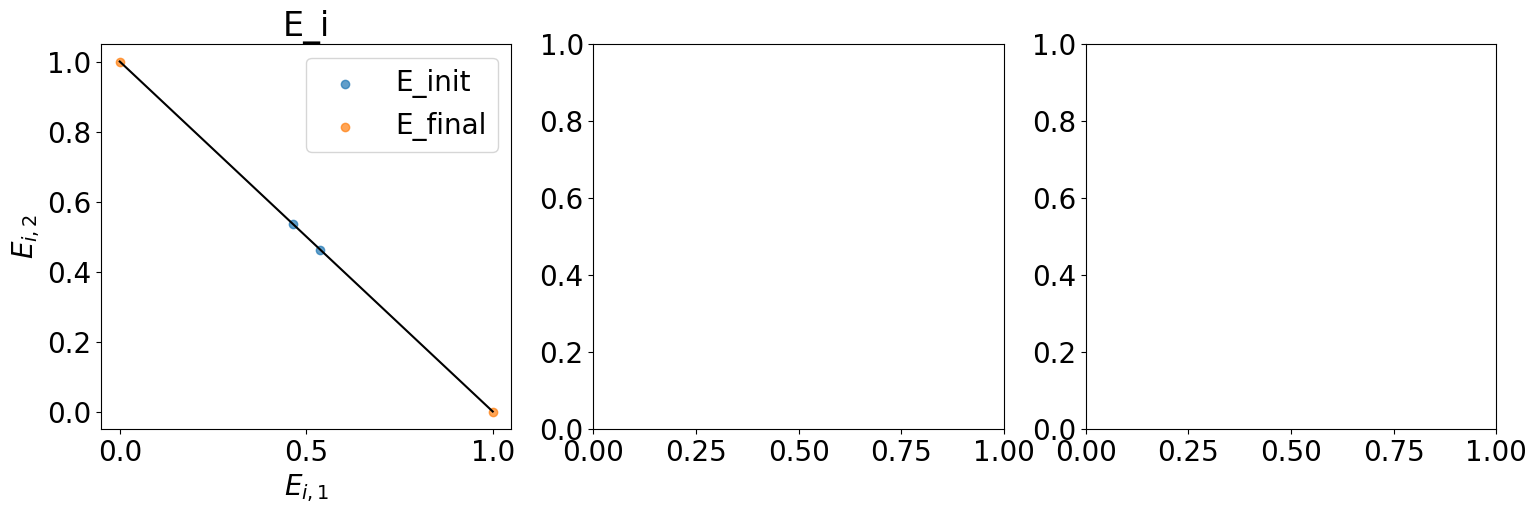

In [55]:
key = jax.random.key(42) 
fig, ax, *_ = plot_activity(init_state.p, state.p, hp, metrics['mi'], key) 
fig.suptitle(f'{hp.activity_model} activity, {hp.odor_model}', y=1.05)
fig.savefig('tmp.png', bbox_inches='tight')

In [46]:
fig.savefig('tmp.png', bbox_inches='tight')

In [35]:
def compute_expression_ratio_neuron(e): 
    se = jnp.sort(e) 
    return se[-1] / jnp.clip(se[-2], min=1e-3) 

def compute_expression_ratios(E): 
    ratios = vmap(compute_expression_ratio_neuron, in_axes=0)(E) 
    return ratios 

def plot_expression(E_init, E_final, mis):
    mosaic = [['E_init', 'E_final', 'MI'],
     ['hist_init', 'hist_final',       '.']]
    fig, axs = plt.subplot_mosaic(mosaic, figsize=(18, 10))
    vmin = min(E_init.min(), E_final.min())
    vmax = max(E_init.max(), E_final.max())
    im1 = axs['E_init'].imshow(E_init, vmin=vmin, vmax=vmax, aspect='auto')
    axs['E_init'].set_title(r'$E_{init}$')
    im2 = axs['E_final'].imshow(E_final, vmin=vmin, vmax=vmax, aspect='auto')
    axs['E_final'].set_title(r'$E_{final}$')
    fig.colorbar(im1, ax=[axs['E_init'], axs['E_final']], location='right', pad=0.1)
    axs['MI'].plot(mis)
    axs['MI'].set_title(r'$\widehat{MI_{JSD}}(r; c)$')
    init_ratios = jnp.log(compute_expression_ratios(E_init))
    final_ratios = jnp.log(compute_expression_ratios(E_final)) 
    axs['hist_init'].hist(init_ratios, alpha=0.7, label=rf'$\langle \log (r_{{E_{{init}}}})\rangle = {jnp.mean(init_ratios):.2f}$')
    axs['hist_final'].hist(final_ratios, alpha=0.7, label=rf'$\langle \log (r_{{E_{{final}}}})\rangle = {jnp.mean(final_ratios):.2f}$')
    [ax.legend() for ax in [axs['hist_init'], axs['hist_final']]]
    ax23 = fig.add_subplot(223, frameon = False)
    ax23.set_xticks([])
    ax23.set_yticks([])
    ax23.set_title(r"$\log(\text{expression ratio})$", loc='right')
    return fig, axs 

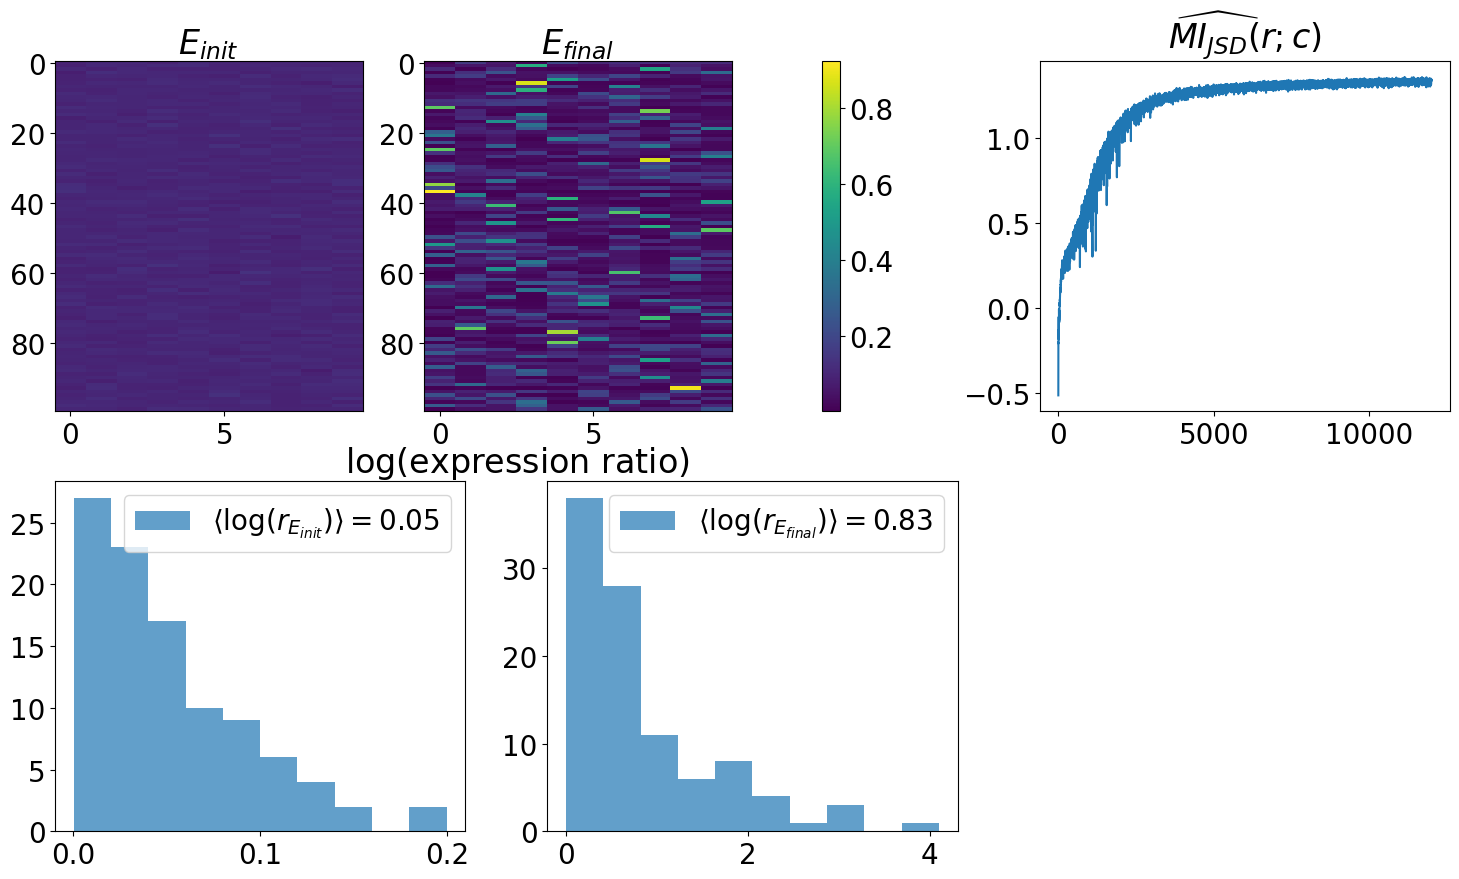

In [36]:
fig, axs = plot_expression(init_state.p.E, state.p.E,  metrics['mi'])
fig.savefig('tmp.png')

In [205]:
axs['E_init'].imshow

<bound method Axes.imshow of <Axes: label='E_init'>>

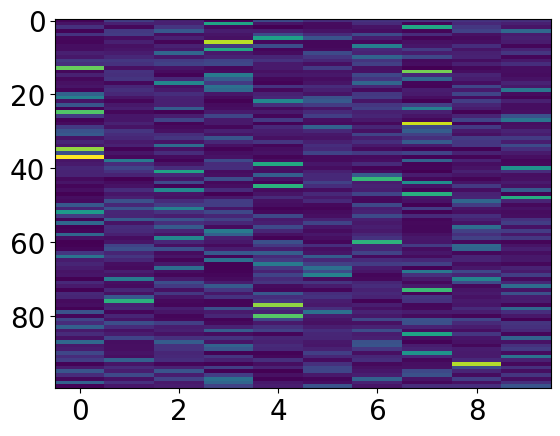

In [160]:
plt.imshow(state.p.E, aspect='auto') 

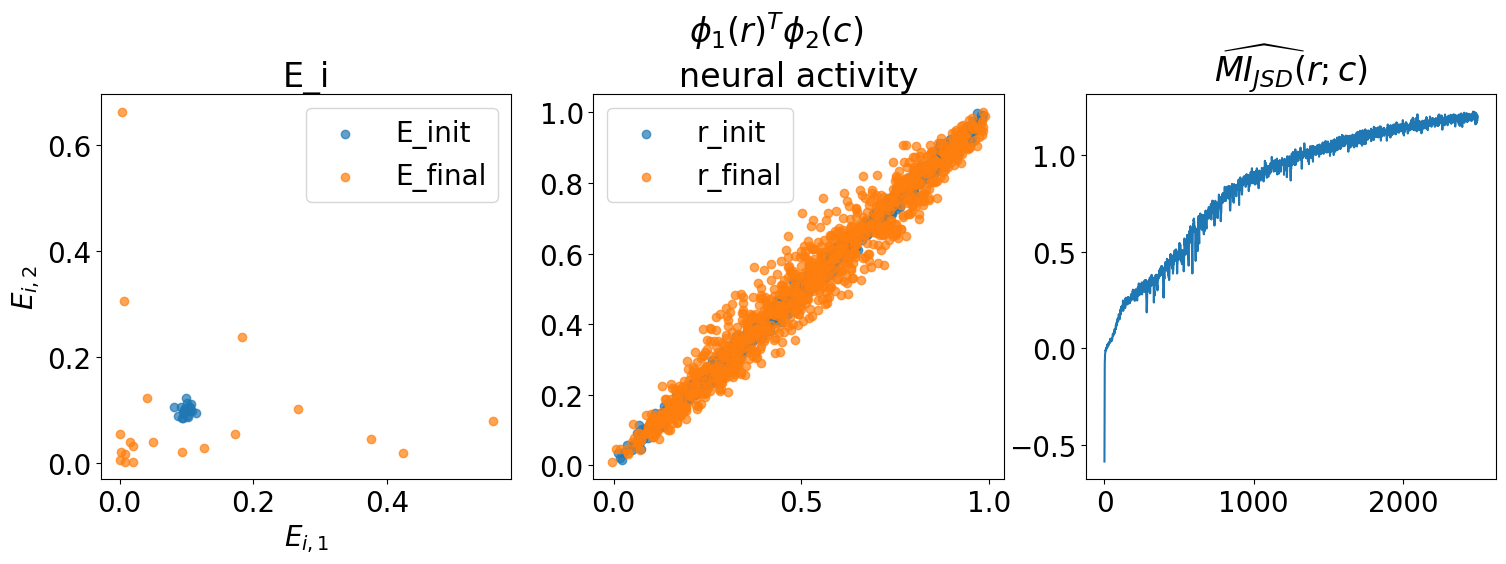

In [150]:
fig, axs, r_init, r_final = plot_activity(p_init, state.p, hp, -1 * metrics['mi'], key=jax.random.key(0)) 
fig.suptitle(r'$\phi_1(r)^T \phi_2(c)$', y=1.05)
fig.savefig('tmp.png', bbox_inches='tight')